In [1]:
from PyQt5.QtGui import QPainter, QFont, QColor, QFontDatabase, QImage, QFontMetrics, QPixmap, QBrush, QPen
from PyQt5.QtCore import QRect, Qt
from PyQt5.QtSvg import QSvgGenerator
from PyQt5.QtWidgets import QApplication
import pandas as pd
import cv2
import numpy as np
import json
import random

app = QApplication([]) # 1 l udaa unshuulahgui bol kernel deer error uguud bsn. ugvul restart hiine


In [2]:
bichmel_fonts = ['../fonts\\Bichimel.ttf', '../fonts\\mnglwritingotf.ttf', '../fonts\\UnicodeFontForShare\\UnicodeFONT MUNKH\\MunkhGalUNICODE\\Menk Hawang.ttf', '../fonts\\UnicodeFontForShare\\UnicodeFONT MUNKH\\Photoshop-iin\\MenksoftGarqag_mirror_0.ttf', '../fonts\\UnicodeFontForShare\\VertNote\\Mongol Bichimel.ttf']

formal_fonts = ['../fonts\\Chagan.ttf', '../fonts\\Garchag.ttf', '../fonts\\mnglwhiteotf.ttf', '../fonts\\Syurga.ttf', '../fonts\\Urga.ttf', '../fonts\\UnicodeFontForShare\\Almas\\mnglwhiteotf.ttf', '../fonts\\UnicodeFontForShare\\Microsoft\\monbaiti 501.ttf', '../fonts\\UnicodeFontForShare\\UnicodeFONT MUNKH\\MunkhGalUNICODE\\Menk Qagan.ttf', '../fonts\\UnicodeFontForShare\\UnicodeFONT MUNKH\\MunkhGalUNICODE\\Menk Sonin.ttf', '../fonts\\UnicodeFontForShare\\VertNote\\Mongol Garchig.ttf']

nariin_font = ['../fonts\\MONGOLIANSYSTEM0.97.TTF', '../fonts\\NotoSansMongolian-Regular.ttf', '../fonts\\UnicodeFontForShare\\Mongol tolbo\\Hutuch\\Hutuch-Light.ttf', '../fonts\\UnicodeFontForShare\\VertNote\\Mongol Web.ttf']

zavaan_font = ['../fonts\\mnglartotf.ttf', '../fonts\\mngltitleotf.ttf', '../fonts\\UnicodeFontForShare\\Almas\\mnglartotf (1).ttf', '../fonts\\UnicodeFontForShare\\UnicodeFONT MUNKH\\MunkhGalUNICODE\\Menk Garqig.ttf', '../fonts\\UnicodeFontForShare\\VertNote\\Mongol Ertny.ttf']

all_fonts = bichmel_fonts + formal_fonts + nariin_font + zavaan_font

In [77]:
def generate_image(path, text, font="../fonts/CMDASHITSEDEN5.91.ttf", font_size = 40, padding = 20):
    # font_path = f"../fonts/{font}"  # Path to the font file
    font_path = font  # Path to the font file
    font_id = QFontDatabase.addApplicationFont(font_path)
    font_family = QFontDatabase.applicationFontFamilies(font_id)[0]

    # Create a QFont object with the loaded font family
    font_obj = QFont(font_family, font_size)

    # Measure the size of the text using QFontMetrics
    font_metrics = QFontMetrics(font_obj)
    text_width = font_metrics.horizontalAdvance(text)
    text_height = font_metrics.height()

    # Add some padding around the text
    
    image_width = text_width + padding * 2
    image_height = text_height + padding * 2

    # Create the QImage object with the calculated dimensions
    image = QImage(image_width, image_height, QImage.Format_ARGB32)
    image.fill(QColor(255, 255, 255))  # Set background to white (or transparent)

    # Create a painter to draw the text on the image
    painter = QPainter(image)
    painter.setFont(font_obj)
    painter.setPen(QColor(0, 0, 0))  # Set the pen color (black)

    # Draw the text, centered in the image
    painter.drawText(padding, text_height+padding - font_size//2, text)  # Positioning based on padding
    painter.end()

    # Save the image as PNG
    image.save(path, "PNG")

In [90]:

BACKGROUND_JSON_PATH = "../dataset/backgrounds.json"

def load_backgrounds():
    with open(BACKGROUND_JSON_PATH, "r") as f:
        return json.load(f)

def apply_random_effects(painter, image_width, image_height):
    effect_type = random.choice(["blur", "shadow", "light", None])
    if effect_type == "blur":
        painter.setOpacity(0.9)
    elif effect_type == "shadow":
        painter.setPen(QPen(QColor(100, 100, 100, 100), 1))
    elif effect_type == "light":
        painter.fillRect(0, 0, image_width, image_height, QColor(255, 255, 255, 30))

def apply_3d_tilt(image_path, output_path):
    image = cv2.imread(image_path)

    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Function to generate random tilting points (within a small range to avoid excessive distortion)
    def generate_random_tilt(tilt_factor=0.3):
        # Generate small random tilts (change the tilt_factor to control the strength of the tilt)
        tilt_x = random.uniform(0, tilt_factor)  # Horizontal tilt
        tilt_y = random.uniform(0, tilt_factor)  # Vertical tilt
        
        print(tilt_x, tilt_x)
        # tilt_x = 0.21574132972407473 
        # tilt_x = 0.1405709864707232
        # Original rectangle coordinates (top-left, top-right, bottom-left, bottom-right)
        pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
        
        # Apply tilt to corners randomly, while ensuring minimal margin change
        pts2 = np.float32([
            [0 + tilt_x * width, 0 + tilt_y * height], 
            [width - tilt_x * width, 0 + tilt_y * height], 
            [0 + tilt_x * width, height - tilt_y * height], 
            [width - tilt_x * width, height - tilt_y * height]
        ])
        
        return pts1, pts2

    # Generate random points for perspective transformation
    pts1, pts2 = generate_random_tilt(tilt_factor=0.3)  # Adjust the tilt factor for more/less tilt

    # Get the perspective transformation matrix
    M_perspective = cv2.getPerspectiveTransform(pts1, pts2)

    # Apply the perspective transformation
    tilted_image = cv2.warpPerspective(image, M_perspective, (width, height))

    # Define a bounding box to crop the image and remove black edges
    # Convert to grayscale and threshold to get non-zero points
    gray = cv2.cvtColor(tilted_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)  # Find all non-zero points

    # Get the bounding box around the non-zero coordinates
    x, y, w, h = cv2.boundingRect(coords)

    cropped_image = tilted_image
    # Crop the image using the bounding box
    cropped_image = tilted_image[y:y+h, x:x+w]

    cv2.imwrite(output_path, cropped_image)

def generate_image_v2(path, text, font="../fonts/CMDASHITSEDEN5.91.ttf", font_size=40, padding=20):
    backgrounds = load_backgrounds()
    selected_bg = random.choice(backgrounds)
    bg_path = selected_bg["path"]
    text_color = selected_bg.get("text_color", [0, 0, 0])

    # Font setup
    font_id = QFontDatabase.addApplicationFont(font)
    font_family = QFontDatabase.applicationFontFamilies(font_id)[0]
    font_obj = QFont(font_family, font_size)

    # Measure text size
    font_metrics = QFontMetrics(font_obj)
    text_width = font_metrics.horizontalAdvance(text)
    text_height = font_metrics.height()

    # Calculate image size
    image_width = text_width + padding * 2
    image_height = text_height + padding * 2

    # Load background
    bg_image = QPixmap(bg_path).scaled(image_width, image_height, Qt.KeepAspectRatioByExpanding, Qt.SmoothTransformation)

    # Create image with background
    image = QImage(image_width, image_height, QImage.Format_ARGB32)
    painter = QPainter(image)
    painter.drawPixmap(0, 0, bg_image)

    # Apply random effects
    apply_random_effects(painter, image_width, image_height)

    # Draw text
    painter.setFont(font_obj)
    painter.setPen(QColor(*text_color))
    painter.drawText(padding, text_height + padding - font_size // 2, text)
    painter.end()

    # Save the image
    image.save(path, "PNG")

    # Apply 3D tilt
    apply_3d_tilt(path, path)




In [91]:
generate_image_v2("test_images/test.png", "ᠰᠦᠢᠷᠡᠨ", font="../fonts/CMDASHITSEDEN5.91.ttf", font_size=40, padding=20)

0.2899087309520246 0.2899087309520246


0.28961612732094666 0.28961612732094666


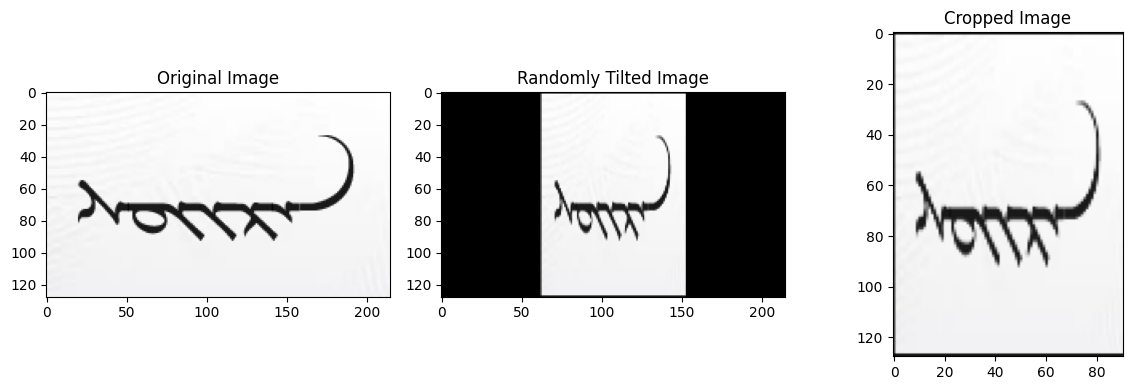

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Load image
image = cv2.imread('test_images/test.png')

# Get the dimensions of the image
height, width = image.shape[:2]

# Function to generate random tilting points (within a small range to avoid excessive distortion)
def generate_random_tilt(tilt_factor=0.3):
    # Generate small random tilts (change the tilt_factor to control the strength of the tilt)
    tilt_x = random.uniform(0, tilt_factor)  # Horizontal tilt
    tilt_y = random.uniform(0, tilt_factor)  # Vertical tilt
    
    print(tilt_x, tilt_x)
    # tilt_x = 0.21574132972407473 
    # tilt_x = 0.1405709864707232
    # Original rectangle coordinates (top-left, top-right, bottom-left, bottom-right)
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    # Apply tilt to corners randomly, while ensuring minimal margin change
    pts2 = np.float32([
        [0 + tilt_x * width, 0 + tilt_y * height], 
        [width - tilt_x * width, 0 + tilt_y * height], 
        [0 + tilt_x * width, height - tilt_y * height], 
        [width - tilt_x * width, height - tilt_y * height]
    ])
    
    return pts1, pts2

# Generate random points for perspective transformation
pts1, pts2 = generate_random_tilt(tilt_factor=0.3)  # Adjust the tilt factor for more/less tilt

# Get the perspective transformation matrix
M_perspective = cv2.getPerspectiveTransform(pts1, pts2)

# Apply the perspective transformation
tilted_image = cv2.warpPerspective(image, M_perspective, (width, height))

# Define a bounding box to crop the image and remove black edges
# Convert to grayscale and threshold to get non-zero points
gray = cv2.cvtColor(tilted_image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
coords = cv2.findNonZero(thresh)  # Find all non-zero points

# Get the bounding box around the non-zero coordinates
x, y, w, h = cv2.boundingRect(coords)

cropped_image = tilted_image
# Crop the image using the bounding box
cropped_image = tilted_image[y:y+h, x:x+w]

cv2.imwrite('cropped_image.png', cropped_image)


In [93]:
path = "../../dataset/tmp1.png"
generate_image(path, "ᠰᠦᠢᠷᠡᠨ\u180eᠡ", bichmel_fonts[0])

In [112]:
i=0
for font in formal_fonts:
    path = f"gen/gen_{i}.png"
    generate_image(path, "ᠰᠦᠢᠷᠡᠨ\u180eᠡ", font)
    i+=1

In [57]:

def generate_comparison_image(path, text, fonts, font_size=40, padding=20):
    """
    Generate an image displaying the given text in multiple fonts for comparison, with bounding boxes and indices.

    :param path: Path to save the generated image.
    :param text: Text to render.
    :param fonts: List of font file names.
    :param font_size: Font size.
    :param padding: Padding around each text row.
    """
    # Load fonts and measure text dimensions
    font_data = []
    max_width = 0
    row_height = 0
    max_index_width = 0  # Track the width of the longest index

    for font in fonts:
        font_path = font
        font_id = QFontDatabase.addApplicationFont(font_path)
        font_family = QFontDatabase.applicationFontFamilies(font_id)[0]

        font_obj = QFont(font_family, font_size)
        font_metrics = QFontMetrics(font_obj)

        text_width = font_metrics.horizontalAdvance(text)
        text_height = font_metrics.height()

        max_width = max(max_width, text_width)
        row_height = max(row_height, text_height + padding * 2)  # Ensure consistent row height

        font_data.append((font_obj, font_family))

    # Calculate final image dimensions
    image_width = max_width + padding * 2
    image_height = row_height * len(fonts)  # Each font gets one row

    # Create the final image
    image = QImage(image_width, image_height, QImage.Format_ARGB32)
    image.fill(QColor(255, 255, 255))  # White background

    painter = QPainter(image)
    painter.setPen(QColor(0, 0, 0))  # Black text

    # Draw text in each font, with bounding boxes and indices
    for i, (font_obj, font_family) in enumerate(font_data):
        y_position = i * row_height + (row_height // 2)  # Center text in row
        painter.setFont(font_obj)
        
        # Calculate the text's bounding box
        font_metrics = QFontMetrics(font_obj)
        text_rect = font_metrics.boundingRect(text)
        text_width = text_rect.width()
        text_height = text_rect.height()
        
        # Draw the bounding box around the text
        painter.setPen(QColor(0, 0, 0))  # Black border for the box
        painter.drawRect(padding - 5, y_position - (text_height // 2) - 5, text_width + 10, text_height + 10)  # Adjust box around the text
        
        # Draw the actual text
        painter.drawText(padding, y_position, text)  # Left-aligned with padding

        # Calculate space required for the index
        index_text = f"{i}"
        index_metrics = font_metrics.boundingRect(index_text)
        index_width = index_metrics.width()

        # Adjust position for the index (right-aligned to the end of the text box with some padding)
        index_x_position = padding + text_width + padding

        # Draw the index at the end of the text row
        painter.drawText(index_x_position, y_position, index_text)

        # Track the width of the longest index for spacing calculations
        max_index_width = max(max_index_width, index_width)

    painter.end()

    # Save the final image
    image.save(path, "PNG")


# Example usage
# generate_comparison_image("output.png", "ᡴᡭᢞᡭᡱᡱᡭᢙᡪᡪᡪᡳ", paths)
generate_comparison_image("output1.png", "ᠭᠠᠷ ᠤᠲᠠᠰᠤ ᠴᠢᠨᠢ", fonts = zavaan_font)


In [2]:
df = pd.read_csv("../../dataset/qa.csv")

In [9]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import uuid

In [ ]:
output_dir = "../../dataset/qa_words"
os.makedirs(output_dir, exist_ok=True)
data = []
df = pd.read_csv("../../dataset/qa.csv")
for idx, row in df.iterrows():
    if len(data)>10000:
        break
    for column in ["question", "answer"]:
        words = row[column].split()
        
        for word in words:
            if len(word) >= 5:
                # selected_fonts = random.sample(all_fonts, min(3, len(all_fonts)))
                selected_fonts=[my_fonts[13]]
                for font in selected_fonts:
                    image_name = f"{uuid.uuid4().hex}.png"
                    image_path = os.path.join(output_dir, image_name)
                    
                    generate_image(image_path, word, font, 40)
                    
                    data.append({
                        "image_path": image_path,
                        "label": word,
                        "font": font
                    })

json_path = os.path.join(output_dir, "data.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Saved metadata to {json_path}")


FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/qa.csv'

In [10]:
random.sample(my_fonts, min(3, len(my_fonts)))

['../../mongolian-nlp/image2bichig/fonts/Bichimel.ttf',
 '../../mongolian-nlp/image2bichig/fonts/Syurga.ttf',
 '../../mongolian-nlp/image2bichig/fonts/mnglwritingotf.ttf']

In [4]:
def plot_character_distribution(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    char_counts = Counter()
    for entry in data:
        char_counts.update(entry["label"])
    
    chars, counts = zip(*char_counts.items())
    
    plt.figure(figsize=(12, 6))
    plt.bar(chars, counts)
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.title("Character Frequency in Labels")
    plt.xticks(rotation=90)
    plt.show()
    
    return char_counts

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\adiya\AppData\Local\Temp\ipykernel_2776\1213786293.py:1: SyntaxWarning: invalid escape sequence '\d'
  c = plot_character_distribution("../../dataset/qa_words\data.json")
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6180 (\N{MONGOLIAN LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6194 (\N{MONGOLIAN LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6176 (\N{MONGOLIAN LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.

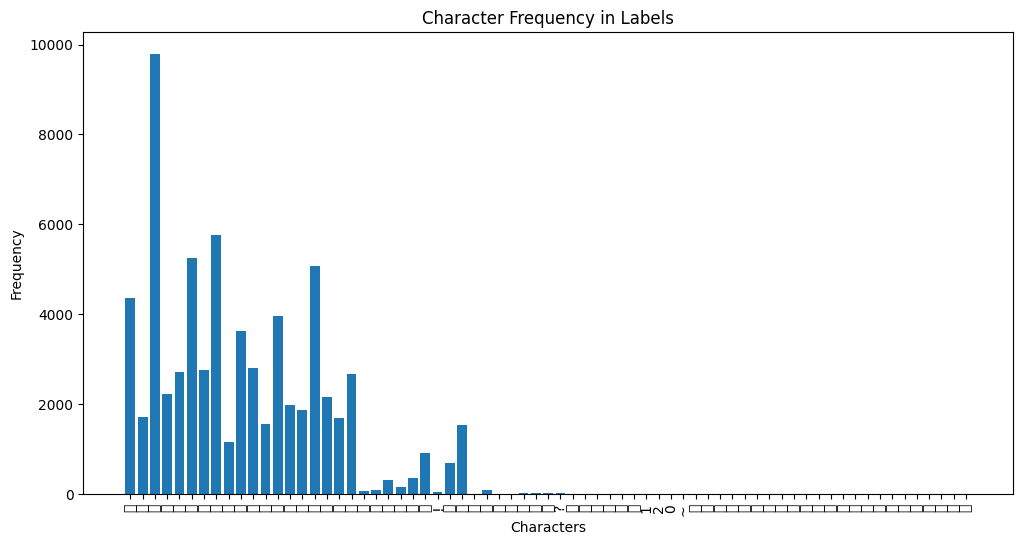

In [6]:
c = plot_character_distribution("../../dataset/qa_words\data.json")

In [7]:
chars, counts = zip(*c.items())

In [ ]:
s=0
mi=1000000
for i in range(len(counts)):
    mi = min(mi, counts[i])
    if counts[i]<10:
        s+=1
        print(chars[i])

︖
ᠹ






1
2
0
~





？




ᠼ














In [84]:
data = []
df = pd.read_csv("../../dataset/qa_dataset/qa.csv")
for idx, row in df.iterrows():
    for column in ["question", "answer"]:
        words = row[column].split()
        for word in words:
            data.append(word)

In [85]:
df1 = pd.read_csv("../../dataset/ocr_dataset/data.csv", names = ["data"])
for idx, row in df1.iterrows():
    path, label = row['data'].split('|')
    words = label.split()
    for word in words:
        data.append(word)

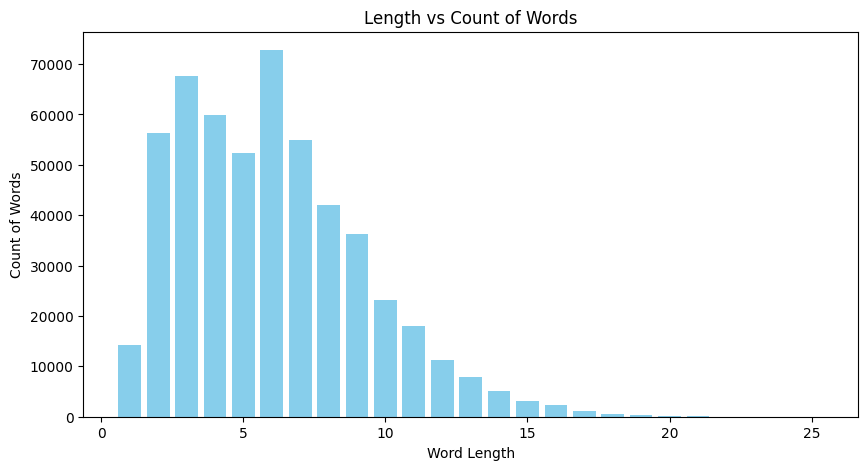

In [62]:
# 1. Length x Count of Words
word_lengths = [len(word) for word in data]
length_counts = Counter(word_lengths)
plt.figure(figsize=(10, 5))
plt.bar(length_counts.keys(), length_counts.values(), color='skyblue')
plt.xlabel('Word Length')
plt.ylabel('Count of Words')
plt.title('Length vs Count of Words')
plt.show()



In [9]:
import matplotlib.font_manager as fm
fm.findSystemFonts(fontext='ttf')

['C:\\Windows\\Fonts\\msyi.ttf',
 'C:\\Windows\\Fonts\\BirchStd.otf',
 'C:\\Windows\\Fonts\\MyriadPro-Bold.otf',
 'C:\\Windows\\Fonts\\AdobeFanHeitiStd-Bold.otf',
 'C:\\Windows\\Fonts\\MesquiteStd.otf',
 'C:\\Windows\\Fonts\\timesbd.ttf',
 'C:\\Windows\\Fonts\\PLAYBILL.TTF',
 'C:\\Windows\\Fonts\\ACaslonPro-Italic.otf',
 'C:\\Windows\\Fonts\\FRADM.TTF',
 'C:\\Windows\\Fonts\\msjhl.ttc',
 'C:\\Windows\\Fonts\\mmrtext.ttf',
 'C:\\Windows\\Fonts\\FRADMIT.TTF',
 'C:\\Windows\\Fonts\\ROCC____.TTF',
 'C:\\Windows\\Fonts\\LeelaUIb.ttf',
 'C:\\Windows\\Fonts\\seguisb.ttf',
 'C:\\Windows\\Fonts\\RAVIE.TTF',
 'C:\\Windows\\Fonts\\phagspab.ttf',
 'C:\\Windows\\Fonts\\AGENCYR.TTF',
 'C:\\Windows\\Fonts\\REFSPCL.TTF',
 'C:\\Windows\\Fonts\\PERTIBD.TTF',
 'C:\\Windows\\Fonts\\BOD_CR.TTF',
 'C:\\Windows\\Fonts\\KozGoPro-Medium.otf',
 'C:\\Windows\\Fonts\\PERTILI.TTF',
 'C:\\Windows\\Fonts\\taile.ttf',
 'C:\\Windows\\Fonts\\KozGoPr6N-ExtraLight.otf',
 'C:\\Windows\\Fonts\\comicz.ttf',
 'C:\\Windows\\F

In [86]:
word_counts = Counter(data)
len(word_counts)

73332

In [87]:
def extract_unicode_set(file_path):
    unicode_set = set()
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Split the line into character and hex value parts
            char, hex_value = line.split('=')
            # Strip spaces and get the hexadecimal part (after 0x)
            hex_value = hex_value.strip().lower().replace('0x', '')
            # Convert the hex value to an integer (Unicode code point)
            code_point = int(hex_value, 16)
            # Convert the code point to the character and add it to the set
            unicode_set.add(chr(code_point))
    
    return unicode_set

# Path to your .txt file
file_path = '../../dataset/myuni.txt'

# Extract the set of Unicode characters
unicode_set = extract_unicode_set(file_path)

In [90]:
def can_be_expressed(word, unicode_chars):
    return all(char in unicode_chars for char in word)
expressed_words_count = [word for word in word_counts if can_be_expressed(word, unicode_set)]
print(f"Number of words that can be expressed: {len(expressed_words_count)}")

Number of words that can be expressed: 18780


In [106]:
len(expressed_words_count)

18780

In [113]:
data = []
output_dir="../../dataset/uniq_words_20k_single_font"
i=0
for word in expressed_words_count:
    i+=1
    if i%1000==999:
        print(f"{i}/{len(expressed_words_count)}")
    # selected_fonts = random.sample(formal_fonts, min(3, len(formal_fonts)))
    selected_fonts = [formal_fonts[2]]
    for font in selected_fonts:
        image_name = f"{uuid.uuid4().hex}.png"
        image_path = os.path.join(output_dir, image_name)
        
        generate_image(image_path, word, font, 40)
        
        data.append({
            "image_path": image_path,
            "label": word,
            "font": font
        })
json_path = "../../dataset/uniq_words_20k_single_font_data.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

999/18780
1999/18780
2999/18780
3999/18780
4999/18780
5999/18780
6999/18780
7999/18780
8999/18780
9999/18780
10999/18780
11999/18780
12999/18780
13999/18780
14999/18780
15999/18780
16999/18780
17999/18780


In [7]:
def can_be_expressed(word, unicode_chars):
    return all(char in unicode_chars for char in word)

words_cannot_expressed = [word for word in word_counts if not can_be_expressed(word, unicode_set)]

# Print a sample of 10 words (or all if there are fewer than 10)
sample = random.sample(words_cannot_expressed, min(10, len(words_cannot_expressed)))

# Print the sample words
print("Sample of words that cannot be expressed:")
for word in sample:
    print(f"Word: {word} | Count: {word_counts[word]}")

NameError: name 'word_counts' is not defined

In [45]:
for word in data:
    if len(word)>30:
        print(word)

ᢔᡪᢋᡭᢙᡪᢊᡪᢑᢛᡪᢋᡭ  ᢘᡪᢙᡪᡪᡪᢙᡪᡪᡪᡳ  ᢚᡪᡳᡪᢞᢑᡪᢑᢚᡪᢋᡭ
ᡴᡭᢞᡭᡱᡱᡭᢙᡪᡪᡪᡳ ᡬᡬᢎᡭᡭᢓ ᡯᡬᢙᡭᢞᡱᡱᡪᢙᡪᡪᡪᡳ ᡥᢎᢚᡬᢑᡪᡱᡱᡭᢑᡪᡪᡳ ᢔᡪᢑᢉᡨ ᡸᡭᡭᡪᡪᡪᡭᢑᢚᡪᡪᡪᡳ ᢗᡬᡪᡪᡪᢚᡪᡪᡪᡳ
ᡸᡭᢎᡴᡭᢉᡨ ᡸᡭᡱᡬᡪᢔᢙᡪᡫ ᡥᡭᡬᡬᡬᡬᢙᡪᡫ ᡸᡭᢑᡬᢚᡪᢉᡨ ᢘᡪᡫ
ᡸᡪᡬᡬᡬᡬᢞᡪᢑᡪᡪᡪᡳ ᡥᡭᢎᡪᢑᢛᡪᡱᡱᡭᢑᡪᡪᡳ  ᢊᡪᢎᢛᡬᡫ ᡨ ᡥᡭᡬᢊᡪᡫ  ᢤᡪᢎᢢᡭᢝ ᢚᡭᡬᢑᡬᡬᡬᢑᢊᡪᢋᡭ ᢔᡪᢞᡬᢔᡭᢑᡪᡪᡪᡳ  ᢗᡪᢛᡬᢑᡪᡪᡪᡳ
ᡥᡪᢑᡳᡪᢚᡫ ᢊᡪᡱᡪᡬᡨ ᡥᡭᡬᢊᡪᡫ ᡬᡪᡳᢙᡭᡱᡱᡪᢙᡪᡫ ᢘᡭᡬᢔᡬᢊᢑᡪᢋᡭ  ᡥᡭᡬᢔᡭᢞᢊᡪᢋᡭ ᢔᡪᡱᡱᡪᢎᡪᢔᡬᢞᡪᡪᡪᡳ ᡸᡪᢞᡬᡪᡪᢑᡪᡪᡪᡳ ᢔᡭᡬᢞᡭᢊᢚᡬᡧ
ᡥᡪᢞᡱᡱᡭᢑᢚᡪᢇ ᡸᡭᡴᡭᢔᡳ ᢔᡪᢊᡪᢑᢊᡪᢋᡭ ᡸᡭᢑᡭᡪᢚᡪᢇ  ᢘᡪᢑᡪᢞᡪᡪᡪᡪᡪᡳ
ᡥᡪᢛᡬᢇ ᡥᡭᡬᢊᡪᡬᡬᡬᡬᢙᡪᢋᡭ ᡥᡭᡧ ᢘᡭᢔᡭᢍ ᡥᡧ ᡬᡬᢞᡭᢊᡪᡳᡪᢚᡫ ᢔᡪᢞᢙᡪᢑᢛᡪᢋᡭᢑᢋᡭ ᡥᢞᢊᡪᢔᡬᢟᡪᡪᡪᡳ ᡷᡭᡬᡪᡬᡨ ᢊᡬᢋᡭ
ᡴᡭᢔᡭᢞᡪᡪᡳ ᡥᡭᢑᡪᡪᡳ ᡴᡭᡬᡬᡬᡬᢗᡬᢐ ᢘᡪᢞᢔᢙᡪᢋᡭ  ᡥᡪᡪᡪᢚᡫ ᢦᢟᢎᢟᡪᢙᢑᡪᢋᡭᢑᢋᡭ ᢗᡪᢑᡪᡳᢑᡪᡪᡪᡳ ᡥᡪᢛᡬᢞᡪᡱᡱᡪᢑᡪᡱᡱᡭᢑᡪᡪᡳ
ᢌᡭᡳᡬᡦ ᡸᡪᡪᡪᡭᢞᡪᡪᡪᡳ ᢘᡪᢑᡳᡬᢞᡪᡪᡪᡳ  ᡸᡪᢞᡪᡱᡱᡭᢑᢙᡪᡪᡪᡳ ᢚᡭᢚᡬᢎᡪᡪᡪᡫ ᢈᡭᢙᡭᡳᡪᢑᢛᡪᡪᡪᡳ ᢚᡬᡪᢊᢊᡬᢝ
ᡸᡪᢑᡪᡪᡪᢑᢛᡪᡪᡪᡳ ᢟᡪᡱᡱᡪᢝ ᡥᢑᡭᡪᢚᡪᡬᡨ ᡥᡭᢞᡳ ᢘᡪᡫ ᡸᡭᡱᡱᡭᢔᡭᢙᡪᡪᡪᡳ  ᢔᡭᡪᢙᡭᡬᡬᡬᡬᡪᡪᡳ  ᡸᡪᡱᡱᡭᢞᢙᡭᡪᡪᡳ ᡥᡭᡬᡭᢊᡪᡬᡬᡬᡬᢑᡪᢋᡭᢑᢋᡭ
ᡬᡪᡳᡬᢑᡪᡱᡱᡭᢑᡪᡪᡳ ᡳᡬᢞᡪᢑᡪᡪᡪᢇ ᡯᡪᡫ ᡥᡭᡬᢊᡪᡫ ᡬᡭᢙᡭᢑᢙᡭᡱᡱᡭᢑᡪᡪᡳ
ᡳᡪᢞᢛᡪᡬᡬᡬᡬᡪᡪᡳ ᡸᡭᢞᡪᢔᡬᡪᡪᡳ ᡥᡪᢞᡪᡪᡪᢇ ᡥᡪᢎᡬᢔᡪᡪᡭᢑᢑᡪᡪᡪᡳ
ᢘᡪᢞᢊᡬᢑᡱᡱᡪᡪᡪᡳ ᢚᡪᡪᢊᢊᡪᢞᢑᡪᢋᡭ ᢗᡬᡱᡪᡭᡪᢊᡪᢋᡭ ᡸᡭᡭᡪᢙᡭᡪᡪᢑᡪᡪᡪᡳ ᡳᡪᢞᡬᢚᡪᢑᢙᡭᡱᡱᡭᢑᡪᡪᡳ ᡥᡪᢔᡪᡱᡱᡪᢑᡱᡱᡭᢝ ᡬᡬᢊᡬᢞᡬᢊᡪᢎᢔᡬᢋᡭ ᡥᡭᡬᡬᢑᡪᢚᡬᢑᡪᢋᡭ
ᡴᡭᡬᢊᡪᢞᡪᢑᢛᡪᢊᡪᡰᡨ ᢥᡭᢑᢑᢟᢊᡬᡦ ᡸᡭᢞᡫ ᢘᡪᢞᡪᡬᡬᡬᡬᢑᡱᡱᡪᡪᡪᡳ ᢘᡪᡪᢊᡱᡪᢑᢛᡭᢝ ᢌᡪᢚᡪᡪᡪᢑ

In [41]:
len(word_counts)


104833

In [24]:

frequencies = list(word_counts.values())


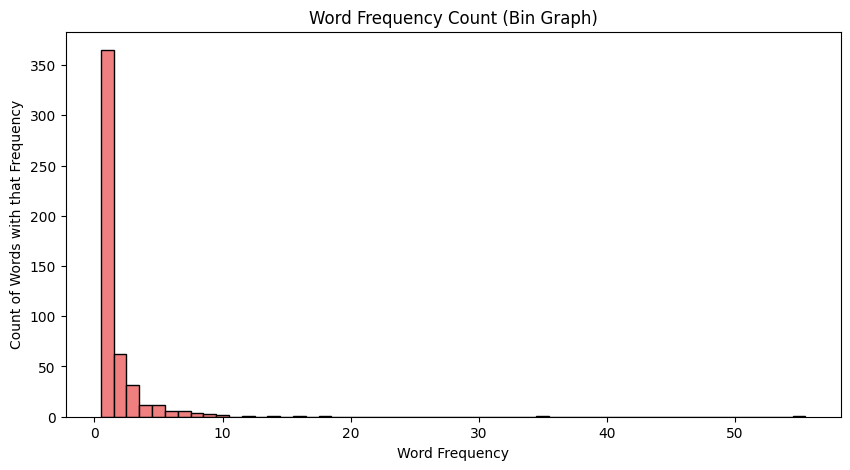

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(frequencies, bins=np.arange(min(frequencies), max(frequencies) + 2) - 0.5, color='lightcoral', edgecolor='black')
plt.xlabel('Word Frequency')
plt.ylabel('Count of Words with that Frequency')
plt.title('Word Frequency Count (Bin Graph)')
plt.show()

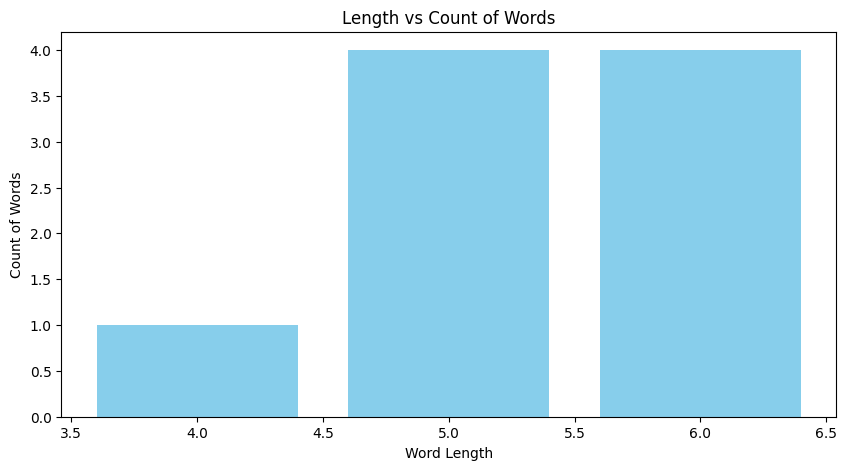

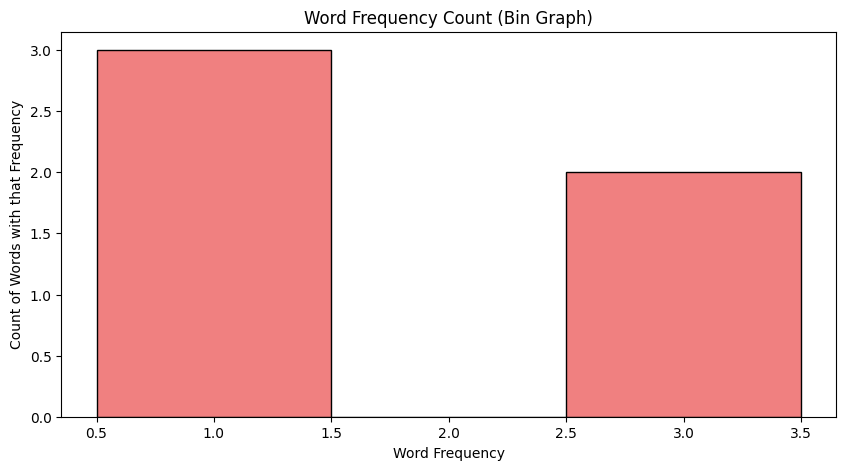

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Sample data (replace this with your actual data)
data = ["apple", "banana", "apple", "orange", "banana", "banana", "grape", "apple", "kiwi"]

# 1. Length x Count of Words
word_lengths = [len(word) for word in data]
length_counts = Counter(word_lengths)
plt.figure(figsize=(10, 5))
plt.bar(length_counts.keys(), length_counts.values(), color='skyblue')
plt.xlabel('Word Length')
plt.ylabel('Count of Words')
plt.title('Length vs Count of Words')
plt.show()

# 2. Word Frequency Count (Bin Graph)
word_counts = Counter(data)
frequencies = list(word_counts.values())
plt.figure(figsize=(10, 5))
plt.hist(frequencies, bins=np.arange(min(frequencies), max(frequencies) + 2) - 0.5, color='lightcoral', edgecolor='black')
plt.xlabel('Word Frequency')
plt.ylabel('Count of Words with that Frequency')
plt.title('Word Frequency Count (Bin Graph)')
plt.show()